<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Import-basic-libraries" data-toc-modified-id="Import-basic-libraries-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Import basic libraries</a></span></li><li><span><a href="#Test-model" data-toc-modified-id="Test-model-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Test model</a></span><ul class="toc-item"><li><span><a href="#wrong_pred_as_cat_high_test" data-toc-modified-id="wrong_pred_as_cat_high_test-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>wrong_pred_as_cat_high_test</a></span></li><li><span><a href="#wrong_pred_as_cat_mid_test" data-toc-modified-id="wrong_pred_as_cat_mid_test-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>wrong_pred_as_cat_mid_test</a></span></li><li><span><a href="#wrong_pred_as_cat_low_test" data-toc-modified-id="wrong_pred_as_cat_low_test-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>wrong_pred_as_cat_low_test</a></span></li><li><span><a href="#wrong_pred_as_dog_high_test" data-toc-modified-id="wrong_pred_as_dog_high_test-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>wrong_pred_as_dog_high_test</a></span></li><li><span><a href="#wrong_pred_as_dog_mid_test" data-toc-modified-id="wrong_pred_as_dog_mid_test-2.5"><span class="toc-item-num">2.5&nbsp;&nbsp;</span>wrong_pred_as_dog_mid_test</a></span></li><li><span><a href="#wrong_pred_as_dog_low_test" data-toc-modified-id="wrong_pred_as_dog_low_test-2.6"><span class="toc-item-num">2.6&nbsp;&nbsp;</span>wrong_pred_as_dog_low_test</a></span><ul class="toc-item"><li><span><a href="#training-set" data-toc-modified-id="training-set-2.6.1"><span class="toc-item-num">2.6.1&nbsp;&nbsp;</span>training set</a></span></li></ul></li><li><span><a href="#wrong_pred_as_cat_high_train" data-toc-modified-id="wrong_pred_as_cat_high_train-2.7"><span class="toc-item-num">2.7&nbsp;&nbsp;</span>wrong_pred_as_cat_high_train</a></span></li><li><span><a href="#wrong_pred_as_cat_mid_train" data-toc-modified-id="wrong_pred_as_cat_mid_train-2.8"><span class="toc-item-num">2.8&nbsp;&nbsp;</span>wrong_pred_as_cat_mid_train</a></span></li></ul></li><li><span><a href="#Distribution-analysis" data-toc-modified-id="Distribution-analysis-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Distribution analysis</a></span></li></ul></div>

# Import basic libraries

In [18]:
from tqdm import tqdm_notebook, tqdm
import numpy as np
import pandas as pd
from imageio import imread
import os
import random
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
import torchvision
import torch.nn as nn
from torchvision import transforms
import warnings
warnings.filterwarnings('ignore')
import scipy

from PIL import Image
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
# ! cp dataset.zip /home/ubuntu/user_space && cd /home/ubuntu/user_space && unzip dataset.zip

In [4]:
train_dir = '/home/ubuntu/user_space/dataset/training_set/training_set'
test_dir = '/home/ubuntu/user_space/dataset/test_set/test_set'

In [5]:
cats_train = os.path.join(train_dir,'cats')
dogs_train = os.path.join(train_dir,'dogs')
cats_test =  os.path.join(test_dir,'cats')
dogs_test =  os.path.join(test_dir,'dogs')

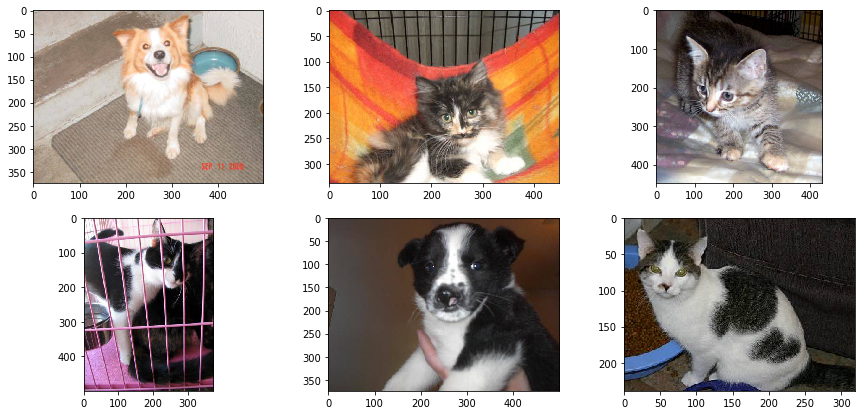

In [6]:
def visualize_image():
    available_image_folders = [cats_train,dogs_train,cats_test,dogs_test]
    plt.figure(figsize=(15,7))
    for i in range(6):
        folder = random.choice(available_image_folders)
        plt.subplot(2,3,i+1)
        imgs_choice = random.choice([i for i in os.listdir(folder)])
        images_path = os.path.join(folder,imgs_choice)
        images = imread(images_path)
        plt.imshow(images)
    plt.show()

visualize_image()

In [7]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

class ImageFolderWithPaths(torchvision.datasets.ImageFolder):    
    def __getitem__(self, index):
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        path = self.imgs[index][0]
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path
    
train_transform = torchvision.transforms.Compose([
    transforms.RandomRotation(20),
    transforms.RandomResizedCrop(size=224, scale=(0.8, 1.0)),
#     transforms.ColorJitter(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)),
    transforms.ToTensor(),
    normalize,
])

test_transform = torchvision.transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    normalize,
])

train_dataloader = torch.utils.data.DataLoader(
    dataset=ImageFolderWithPaths(train_dir, transform=train_transform),
    shuffle=True, 
    batch_size=32, 
    num_workers=3
)

test_dataloader = torch.utils.data.DataLoader(
    dataset=ImageFolderWithPaths(test_dir, transform=test_transform),
    shuffle=True,
    batch_size=32,
    num_workers=3
)

In [8]:
print(len(train_dataloader), len(test_dataloader))

251 64


In [8]:
model = torchvision.models.resnet50(pretrained=True).to(device)

In [9]:
# ! cp ../resnet50-19c8e357.pth /home/ubuntu/.cache/torch/checkpoints/
# ! cp /home/ubuntu/.cache/torch/checkpoints/resnet18-5c106cde.pth models

In [10]:
# for params in model.parameters():
#     params.requires_grads = False
model.fc = nn.Sequential(
    nn.Linear(2048,2),
).to(device)

# model.fc = nn.Sequential(
#     nn.Linear(2048,512),
#     nn.ReLU(inplace=True),
#     nn.Linear(512,2)
# ).to(device)

criterian = nn.CrossEntropyLoss()
optimizers = torch.optim.Adam(model.fc.parameters(), lr=0.001)

In [ ]:
print('[INFO] training')
n_epochs = 20

loss_history, acc_history = [], []
for epoch in tqdm_notebook(range(n_epochs)):
    model.train()
    correct, total = 0., 0.
    for batch_idx, (data, labels, _) in tqdm_notebook(enumerate(train_dataloader)):
        data = data.to(device)
        labels = labels.to(device)
        optimizers.zero_grad()
        output = model(data)
        loss = criterian(output,labels)
        loss.backward()
        optimizers.step()
        
        pred_scores = F.softmax(output, dim=1)
        pred_labels = torch.max(pred_scores, axis=1)[1]
        correct += (pred_labels==labels.long()).sum().item()
        total += labels.shape[0]
        acc = round(float(correct)/total, 4)
        
        loss_history.append(loss.item())
        acc_history.append(acc)
            
        if batch_idx % 20 == 0:
            print('epoch: {}, batch_idx: {}, loss: {}, acc: {}'.format(
                epoch, batch_idx, round(loss.item(), 4), acc))
    if acc > 0.95:
        torch.save(model.state_dict(),'./models/resnet50-epoch{}-Acc{}.h5'.format(epoch, int(acc*10000)))

[INFO] training


epoch: 0, batch_idx: 0, loss: 0.8079, acc: 0.375
epoch: 0, batch_idx: 20, loss: 0.2993, acc: 0.6994
epoch: 0, batch_idx: 40, loss: 0.1262, acc: 0.83
epoch: 0, batch_idx: 60, loss: 0.0862, acc: 0.8678
epoch: 0, batch_idx: 80, loss: 0.1332, acc: 0.88
epoch: 0, batch_idx: 100, loss: 0.1579, acc: 0.8936
epoch: 0, batch_idx: 120, loss: 0.0551, acc: 0.9062
epoch: 0, batch_idx: 140, loss: 0.0701, acc: 0.9158
epoch: 0, batch_idx: 160, loss: 0.0389, acc: 0.9216
epoch: 0, batch_idx: 180, loss: 0.2492, acc: 0.9252
epoch: 0, batch_idx: 200, loss: 0.0473, acc: 0.93
epoch: 0, batch_idx: 220, loss: 0.3588, acc: 0.9328
epoch: 0, batch_idx: 240, loss: 0.0424, acc: 0.9354



epoch: 1, batch_idx: 0, loss: 0.059, acc: 0.9688
epoch: 1, batch_idx: 20, loss: 0.124, acc: 0.9598
epoch: 1, batch_idx: 40, loss: 0.0653, acc: 0.9627
epoch: 1, batch_idx: 60, loss: 0.1109, acc: 0.9606
epoch: 1, batch_idx: 80, loss: 0.0398, acc: 0.9633
epoch: 1, batch_idx: 100, loss: 0.0803, acc: 0.965
epoch: 1, batch_idx: 120, loss: 0.1241, acc: 0.9636
epoch: 1, batch_idx: 140, loss: 0.1066, acc: 0.9645
epoch: 1, batch_idx: 160, loss: 0.0354, acc: 0.9658
epoch: 1, batch_idx: 180, loss: 0.0665, acc: 0.967
epoch: 1, batch_idx: 200, loss: 0.038, acc: 0.9674
epoch: 1, batch_idx: 220, loss: 0.1271, acc: 0.9675
epoch: 1, batch_idx: 240, loss: 0.0412, acc: 0.9676



epoch: 2, batch_idx: 0, loss: 0.1402, acc: 0.9688
epoch: 2, batch_idx: 20, loss: 0.0531, acc: 0.9464
epoch: 2, batch_idx: 40, loss: 0.0554, acc: 0.952
epoch: 2, batch_idx: 60, loss: 0.049, acc: 0.96
epoch: 2, batch_idx: 80, loss: 0.0165, acc: 0.9599
epoch: 2, batch_idx: 100, loss: 0.0787, acc: 0.9592
epoch: 2, batch_idx: 120, loss: 0.2566, acc: 0.9592
epoch: 2, batch_idx: 140, loss: 0.0621, acc: 0.9603
epoch: 2, batch_idx: 160, loss: 0.089, acc: 0.9622
epoch: 2, batch_idx: 180, loss: 0.0474, acc: 0.9624
epoch: 2, batch_idx: 200, loss: 0.0453, acc: 0.963
epoch: 2, batch_idx: 220, loss: 0.1472, acc: 0.9632
epoch: 2, batch_idx: 240, loss: 0.0244, acc: 0.9629



epoch: 3, batch_idx: 0, loss: 0.0847, acc: 0.9375
epoch: 3, batch_idx: 20, loss: 0.1979, acc: 0.9673
epoch: 3, batch_idx: 40, loss: 0.0223, acc: 0.9665
epoch: 3, batch_idx: 60, loss: 0.0785, acc: 0.9672
epoch: 3, batch_idx: 80, loss: 0.2462, acc: 0.9699
epoch: 3, batch_idx: 100, loss: 0.1015, acc: 0.9712
epoch: 3, batch_idx: 120, loss: 0.0163, acc: 0.9698
epoch: 3, batch_idx: 140, loss: 0.0351, acc: 0.9699
epoch: 3, batch_idx: 160, loss: 0.0968, acc: 0.9697
epoch: 3, batch_idx: 180, loss: 0.1516, acc: 0.9701
epoch: 3, batch_idx: 200, loss: 0.0669, acc: 0.9703
epoch: 3, batch_idx: 220, loss: 0.105, acc: 0.9692
epoch: 3, batch_idx: 240, loss: 0.0096, acc: 0.9695



epoch: 4, batch_idx: 0, loss: 0.0254, acc: 1.0
epoch: 4, batch_idx: 20, loss: 0.1286, acc: 0.9524
epoch: 4, batch_idx: 40, loss: 0.0283, acc: 0.9566
epoch: 4, batch_idx: 60, loss: 0.0803, acc: 0.9621
epoch: 4, batch_idx: 80, loss: 0.1678, acc: 0.9603
epoch: 4, batch_idx: 100, loss: 0.0262, acc: 0.9629
epoch: 4, batch_idx: 120, loss: 0.1569, acc: 0.962
epoch: 4, batch_idx: 140, loss: 0.1616, acc: 0.9637
epoch: 4, batch_idx: 160, loss: 0.0036, acc: 0.9651
epoch: 4, batch_idx: 180, loss: 0.1294, acc: 0.9639
epoch: 4, batch_idx: 200, loss: 0.078, acc: 0.9628
epoch: 4, batch_idx: 220, loss: 0.013, acc: 0.9638
epoch: 4, batch_idx: 240, loss: 0.0285, acc: 0.965



epoch: 5, batch_idx: 0, loss: 0.1092, acc: 0.9688
epoch: 5, batch_idx: 20, loss: 0.0683, acc: 0.9643
epoch: 5, batch_idx: 40, loss: 0.0342, acc: 0.9611
epoch: 5, batch_idx: 60, loss: 0.1717, acc: 0.9636
epoch: 5, batch_idx: 80, loss: 0.2233, acc: 0.9649
epoch: 5, batch_idx: 100, loss: 0.0068, acc: 0.9669
epoch: 5, batch_idx: 120, loss: 0.23, acc: 0.969
epoch: 5, batch_idx: 140, loss: 0.0431, acc: 0.9696
epoch: 5, batch_idx: 160, loss: 0.0468, acc: 0.9699
epoch: 5, batch_idx: 180, loss: 0.0518, acc: 0.9693
epoch: 5, batch_idx: 200, loss: 0.2472, acc: 0.9663
epoch: 5, batch_idx: 220, loss: 0.0112, acc: 0.9658
epoch: 5, batch_idx: 240, loss: 0.0219, acc: 0.9667



epoch: 6, batch_idx: 0, loss: 0.0056, acc: 1.0
epoch: 6, batch_idx: 20, loss: 0.0128, acc: 0.9792
epoch: 6, batch_idx: 40, loss: 0.0302, acc: 0.9779
epoch: 6, batch_idx: 60, loss: 0.2222, acc: 0.9744
epoch: 6, batch_idx: 80, loss: 0.0407, acc: 0.9691
epoch: 6, batch_idx: 100, loss: 0.0881, acc: 0.9703
epoch: 6, batch_idx: 120, loss: 0.0042, acc: 0.9698
epoch: 6, batch_idx: 140, loss: 0.1397, acc: 0.9703
epoch: 6, batch_idx: 160, loss: 0.0093, acc: 0.9695
epoch: 6, batch_idx: 180, loss: 0.035, acc: 0.9706
epoch: 6, batch_idx: 200, loss: 0.0567, acc: 0.9708
epoch: 6, batch_idx: 220, loss: 0.0137, acc: 0.9717
epoch: 6, batch_idx: 240, loss: 0.0499, acc: 0.9712



epoch: 7, batch_idx: 0, loss: 0.2208, acc: 0.875
epoch: 7, batch_idx: 20, loss: 0.0061, acc: 0.9673
epoch: 7, batch_idx: 40, loss: 0.0951, acc: 0.9649
epoch: 7, batch_idx: 60, loss: 0.0329, acc: 0.9652
epoch: 7, batch_idx: 80, loss: 0.0123, acc: 0.966
epoch: 7, batch_idx: 100, loss: 0.0222, acc: 0.9657
epoch: 7, batch_idx: 120, loss: 0.005, acc: 0.9675


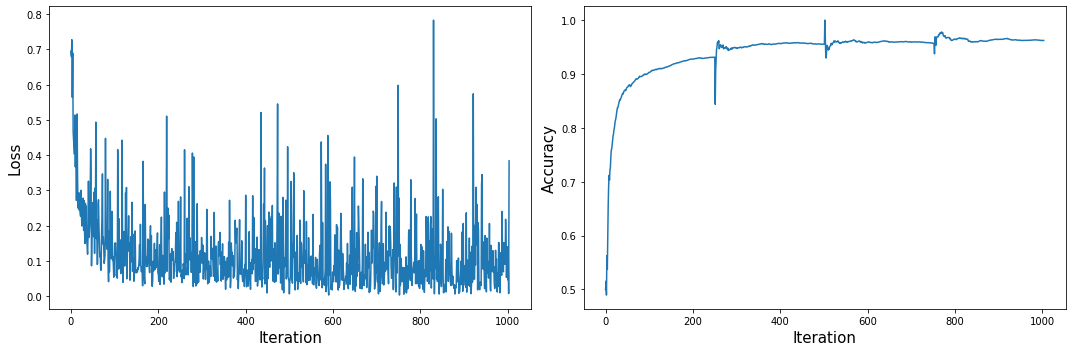

In [14]:
fig = plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(loss_history)
plt.xlabel('Iteration', fontsize=15)
plt.ylabel('Loss', fontsize=15)

plt.subplot(1, 2, 2)
plt.plot(acc_history)
plt.xlabel('Iteration', fontsize=15)
plt.ylabel('Accuracy', fontsize=15)

plt.tight_layout()

In [ ]:
torch.save(model.state_dict(),'./models/resnet50-Acc{}.h5'.format(int(acc*10000)))

test_imgs = ['/cats/cat.4001.jpg',
             '/cats/cat.4003.jpg',
             '/dogs/dog.4004.jpg',
             '/dogs/dog.4006.jpg']
img_list = [Image.open(test_dir + img_path) for img_path in test_imgs]

test_batch = torch.stack([test_transform(img).to(device)
                                for img in img_list])

pred_logits_tensor = model(test_batch)
pred_probs = nn.functional.softmax(pred_logits_tensor, dim=1).cpu().data.numpy()
print(pred_probs)

In [ ]:
fig, axs = plt.subplots(1, len(img_list), figsize=(20, 5))
for i, img in enumerate(img_list):
    ax = axs[i]
    ax.axis('off')
    ax.set_title("{:.0f}% Cat, {:.0f}% Dog".format(100*pred_probs[i,0],
                                                            100*pred_probs[i,1]))
    ax.imshow(img)

# Test model

In [10]:
# ! mkdir /home/ubuntu/.cache
# ! mkdir /home/ubuntu/.cache/torch
# ! mkdir /home/ubuntu/.cache/torch/checkpoints
# ! cp models/resnet50-19c8e357.pth /home/ubuntu/.cache/torch/checkpoints/

mkdir: 无法创建目录"/home/ubuntu/.cache": 文件已存在
mkdir: 无法创建目录"/home/ubuntu/.cache/torch": 文件已存在
mkdir: 无法创建目录"/home/ubuntu/.cache/torch/checkpoints": 文件已存在


In [11]:
model = torchvision.models.resnet50(pretrained=True).to(device)
model.fc = nn.Sequential(
    nn.Linear(2048,2),
).to(device)

model.load_state_dict(torch.load('./models/resnet50-epoch6-Acc9715.h5'))

<All keys matched successfully>

In [12]:
train_dataloader_tmp = torch.utils.data.DataLoader(
    dataset=ImageFolderWithPaths(train_dir, transform=train_transform),
    shuffle=True, 
    batch_size=8, 
    num_workers=3
)

test_dataloader_tmp = torch.utils.data.DataLoader(
    dataset=ImageFolderWithPaths(test_dir, transform=test_transform),
    shuffle=True,
    batch_size=8,
    num_workers=3
)

def predict(dataloader):
    model.eval()
    correct, total = 0., 0.
    for batch_idx, (data, labels, _) in tqdm_notebook(enumerate(dataloader)):
        data = data.to(device)
        labels = labels.to(device)
        output = model(data)

        pred_scores = F.softmax(output, dim=1)
        pred_labels = torch.max(pred_scores, axis=1)[1]
        correct += (pred_labels==labels.long()).sum().item()
        total += labels.shape[0]
        acc = round(float(correct)/total, 4)
    return acc

acc_train = predict(train_dataloader_tmp)
acc_test = predict(test_dataloader_tmp)
print('acc_train: {}, acc_test: {}'.format(acc_train, acc_test))


acc_train: 0.9809, acc_test: 0.9812


In [13]:
def calc_res(dataloader):
    model.eval()
    correct, total = 0., 0.
    
    pred_labels_list, true_labels_list, scores_list, logits_list = [], [], [], []
    img_path_list = []
    
    for batch_idx, (data, labels, paths) in tqdm_notebook(enumerate(dataloader)):
        data = data.to(device)
        labels = labels.to(device)
        output = model(data)
        pred_scores = F.softmax(output, dim=1)
        pred_labels = torch.max(pred_scores, axis=1)[1]        
        correct += (pred_labels==labels.long()).sum().item()
        total += labels.shape[0]
        acc = round(float(correct)/total, 4)
        
        logits = output.cpu().detach().numpy()
        pred_scores = pred_scores.cpu().detach().numpy()
        pred_labels = pred_labels.cpu().detach().numpy()
        true_labels = labels.cpu().detach().numpy()
        
        true_labels_list.extend(true_labels)
        pred_labels_list.extend(pred_labels)
        scores_list.extend(pred_scores)
        logits_list.extend(logits)
        img_path_list.extend(paths)
        
    true_labels_arr = np.array(true_labels_list).reshape(-1, 1)
    pred_labels_arr = np.array(pred_labels_list).reshape(-1, 1)
    scores_arr = np.array(scores_list)
    logits_arr = np.array(logits_list)
    
    return img_path_list, true_labels_arr, pred_labels_arr, scores_arr, logits_arr

img_path_train, true_labels_train, pred_labels_train, scores_train, logits_train = calc_res(train_dataloader_tmp)
img_path_test, true_labels_test, pred_labels_test, scores_test, logits_test = calc_res(test_dataloader_tmp)

print(true_labels_train.shape, pred_labels_train.shape, scores_train.shape, logits_train.shape)
print(true_labels_test.shape, pred_labels_test.shape, scores_test.shape, logits_test.shape)


(8005, 1) (8005, 1) (8005, 2) (8005, 2)
(2023, 1) (2023, 1) (2023, 2) (2023, 2)


In [14]:
def divide_pred_results(img_path_arr, true_labels_arr, pred_labels_arr, scores_arr, logits_arr):
    wrong_pred_as_cat_high, wrong_pred_as_cat_mid, wrong_pred_as_cat_low = [], [], []
    wrong_pred_as_dog_high, wrong_pred_as_dog_mid, wrong_pred_as_dog_low = [], [], []

    for idx in range(true_labels_test.shape[0]):
        img_path = img_path_arr[idx]
        true_label = true_labels_arr[idx][0]
        pred_label = pred_labels_arr[idx][0]
        cat_score = scores_arr[idx,:][0]
        dog_score = scores_arr[idx,:][1]
        logits = logits_arr[idx, :]
        info = [img_path, true_label, pred_label, cat_score, dog_score, [logits[0], logits[1]]]
        
        if true_label == 0 and pred_label == 1:
            if dog_score > 0.7:   # pred as a high score for wrong label, i.e. dog
                wrong_pred_as_cat_high.append(info)
            elif dog_score > 0.6:
                wrong_pred_as_cat_mid.append(info)
            else:
                wrong_pred_as_cat_low.append(info)
        elif true_label == 1 and pred_label == 0:
            if cat_score > 0.7:
                wrong_pred_as_dog_high.append(info)
            elif cat_score > 0.6:
                wrong_pred_as_dog_mid.append(info)
            else:
                wrong_pred_as_dog_low.append(info)

    print('cat, high: {}, mid: {}, low: {}'.format(
        len(wrong_pred_as_cat_high), len(wrong_pred_as_cat_mid), len(wrong_pred_as_cat_low)))
    print('dog, high: {}, mid: {}, low: {}'.format(
        len(wrong_pred_as_dog_high), len(wrong_pred_as_dog_mid), len(wrong_pred_as_dog_low)))
    return wrong_pred_as_cat_high, wrong_pred_as_cat_mid, wrong_pred_as_cat_low, wrong_pred_as_dog_high, wrong_pred_as_dog_mid, wrong_pred_as_dog_low

wrong_pred_as_cat_high_train, wrong_pred_as_cat_mid_train, wrong_pred_as_cat_low_train, wrong_pred_as_dog_high_train, wrong_pred_as_dog_mid_train, wrong_pred_as_dog_low_train = divide_pred_results(img_path_train, true_labels_train, pred_labels_train, scores_train, logits_train)
wrong_pred_as_cat_high_test, wrong_pred_as_cat_mid_test, wrong_pred_as_cat_low_test, wrong_pred_as_dog_high_test, wrong_pred_as_dog_mid_test, wrong_pred_as_dog_low_test = divide_pred_results(img_path_test, true_labels_test, pred_labels_test, scores_test, logits_test)

cat, high: 5, mid: 2, low: 4
dog, high: 19, mid: 9, low: 6
cat, high: 3, mid: 1, low: 1
dog, high: 20, mid: 6, low: 7


In [15]:
wrong_pred_as_cat_high_test[0]

['/home/ubuntu/user_space/dataset/test_set/test_set/cats/cat.4190.jpg',
 0,
 1,
 0.27845734,
 0.72154266,
 [0.09883666, 1.0509633]]

## wrong_pred_as_cat_high_test

img_list ['/home/ubuntu/user_space/dataset/test_set/test_set/cats/cat.4190.jpg', '/home/ubuntu/user_space/dataset/test_set/test_set/cats/cat.4008.jpg', '/home/ubuntu/user_space/dataset/test_set/test_set/cats/cat.4085.jpg']


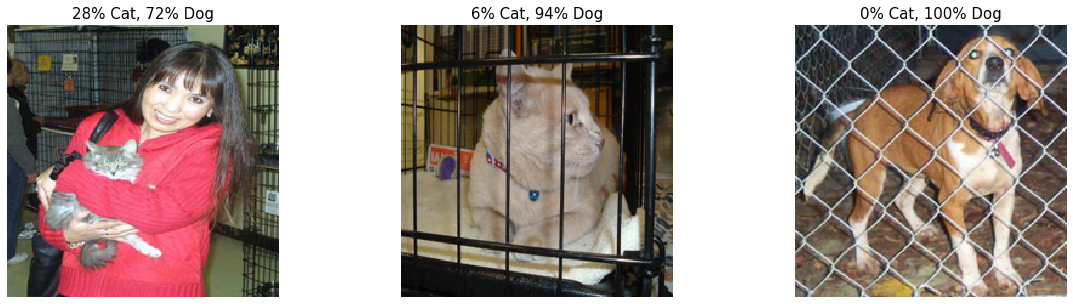

In [16]:
def plot_img(img_info_list):
    img_list = [i[0] for i in img_info_list][:5]
    print('img_list', img_list)
    img_list = [Image.open(img_path).resize((224, 224)) for img_path in img_list]

    if len(img_list) > 1:
        fig, axs = plt.subplots(1, len(img_list), figsize=(20, 5))
        for idx, img in enumerate(img_list):
            ax = axs[idx]
            ax.axis('off')

            ax.set_title("{:.0f}% Cat, {:.0f}% Dog".format(100*img_info_list[idx][3],
                                                                    100*img_info_list[idx][4]), fontsize=15)
            ax.imshow(img)
    else:
        fig = plt.figure()
        img = img_list[0]
        plt.title("{:.0f}% Cat, {:.0f}% Dog".format(100*img_info_list[0][3],100*img_info_list[0][4]), fontsize=15)
        plt.axis('off')
        plt.imshow(img)
        
    plt.show()

plot_img(wrong_pred_as_cat_high_test)

## wrong_pred_as_cat_mid_test

img_list ['/home/ubuntu/user_space/dataset/test_set/test_set/cats/cat.4992.jpg']


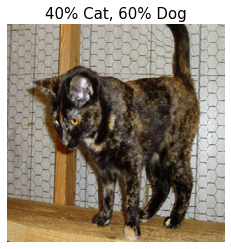

In [70]:
plot_img(wrong_pred_as_cat_mid_test)

## wrong_pred_as_cat_low_test

img_list ['/home/ubuntu/user_space/dataset/test_set/test_set/cats/cat.4986.jpg']


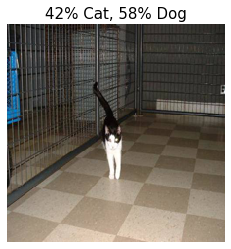

In [71]:
plot_img(wrong_pred_as_cat_low_test)

## wrong_pred_as_dog_high_test

img_list ['/home/ubuntu/user_space/dataset/test_set/test_set/dogs/dog.4800.jpg', '/home/ubuntu/user_space/dataset/test_set/test_set/dogs/dog.4987.jpg', '/home/ubuntu/user_space/dataset/test_set/test_set/dogs/dog.4254.jpg', '/home/ubuntu/user_space/dataset/test_set/test_set/dogs/dog.4171.jpg', '/home/ubuntu/user_space/dataset/test_set/test_set/dogs/dog.4507.jpg']


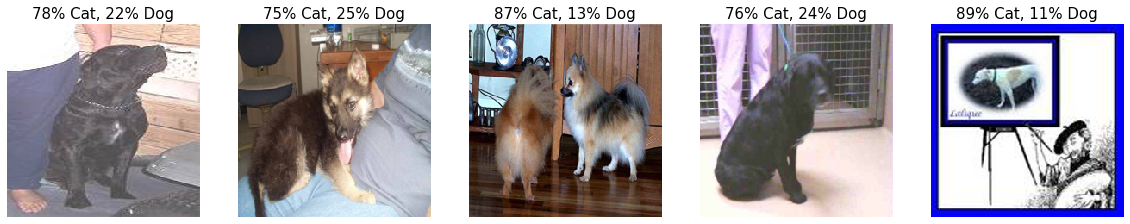

In [72]:
plot_img(wrong_pred_as_dog_high_test)

## wrong_pred_as_dog_mid_test

img_list ['/home/ubuntu/user_space/dataset/test_set/test_set/dogs/dog.4468.jpg', '/home/ubuntu/user_space/dataset/test_set/test_set/dogs/dog.4474.jpg', '/home/ubuntu/user_space/dataset/test_set/test_set/dogs/dog.4320.jpg', '/home/ubuntu/user_space/dataset/test_set/test_set/dogs/dog.4140.jpg', '/home/ubuntu/user_space/dataset/test_set/test_set/dogs/dog.4984.jpg']


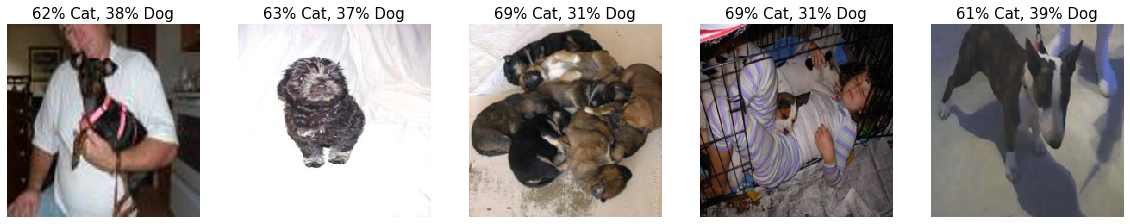

In [73]:
plot_img(wrong_pred_as_dog_mid_test)

## wrong_pred_as_dog_low_test

img_list ['/home/ubuntu/user_space/dataset/test_set/test_set/dogs/dog.4494.jpg', '/home/ubuntu/user_space/dataset/test_set/test_set/dogs/dog.4829.jpg', '/home/ubuntu/user_space/dataset/test_set/test_set/dogs/dog.4180.jpg', '/home/ubuntu/user_space/dataset/test_set/test_set/dogs/dog.4551.jpg', '/home/ubuntu/user_space/dataset/test_set/test_set/dogs/dog.4421.jpg']


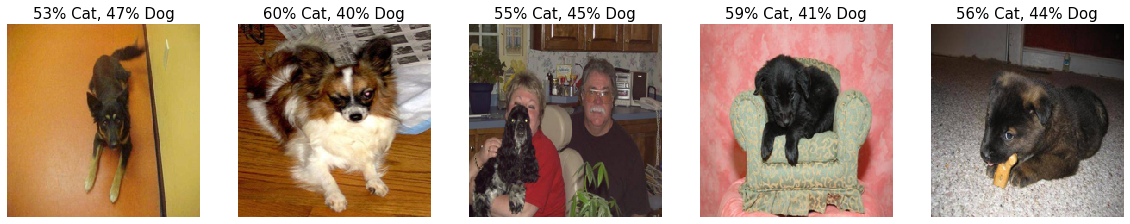

In [74]:
plot_img(wrong_pred_as_dog_low_test)

### training set

## wrong_pred_as_cat_high_train

img_list ['/home/ubuntu/user_space/dataset/training_set/training_set/cats/cat.1276.jpg']


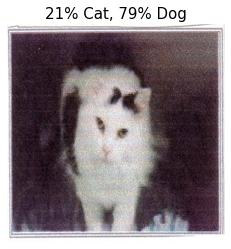

In [75]:
plot_img(wrong_pred_as_cat_high_train)

## wrong_pred_as_cat_mid_train

img_list ['/home/ubuntu/user_space/dataset/training_set/training_set/cats/cat.3858.jpg', '/home/ubuntu/user_space/dataset/training_set/training_set/cats/cat.2938.jpg']


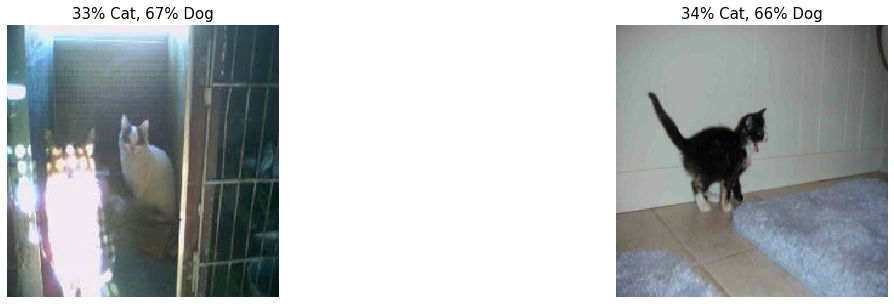

In [76]:
plot_img(wrong_pred_as_cat_mid_train)

# Distribution analysis

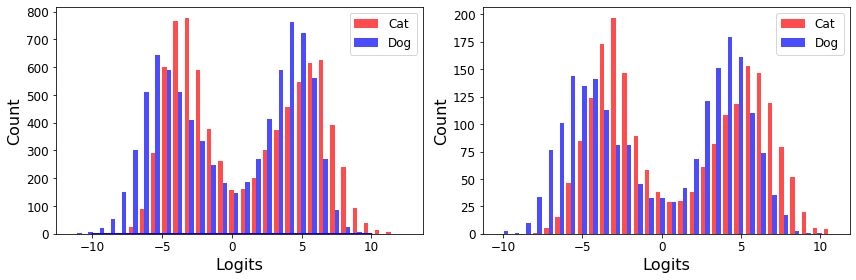

In [22]:
fig = plt.figure(figsize=(12, 4))
fig.add_subplot(1, 2, 1)
plt.hist([logits_train[:, 0], logits_train[:, 1]], color=['r', 'b'], alpha=0.7, bins=30, label=['Cat', 'Dog'])
plt.xlabel('Logits', fontsize=16)
plt.ylabel('Count', fontsize=16)
plt.legend(fontsize=12)
# kde
kde_cat_train = scipy.stats.gaussian_kde(logits_train[:,0])
kde_dog_train = scipy.stats.gaussian_kde(logits_train[:,1])
xs = np.linspace(-10, 10, num=50)
y_cat = kde_cat_train(xs)
y_dog = kde_dog_train(xs)
plt.plot(xs, y_cat, c='red', label='Cat')
plt.plot(xs, y_dog, c='blue', label='Cat')
plt.tick_params(labelsize=12)

fig.add_subplot(1, 2, 2)
plt.hist([logits_test[:, 0], logits_test[:, 1]], color=['r', 'b'], alpha=0.7, bins=30, label=['Cat', 'Dog'])
plt.xlabel('Logits', fontsize=16)
plt.ylabel('Count', fontsize=16)
plt.legend(fontsize=12)
plt.tick_params(labelsize=12)

plt.tight_layout()
plt.savefig('./plot/logits.jpg', dpi=300)

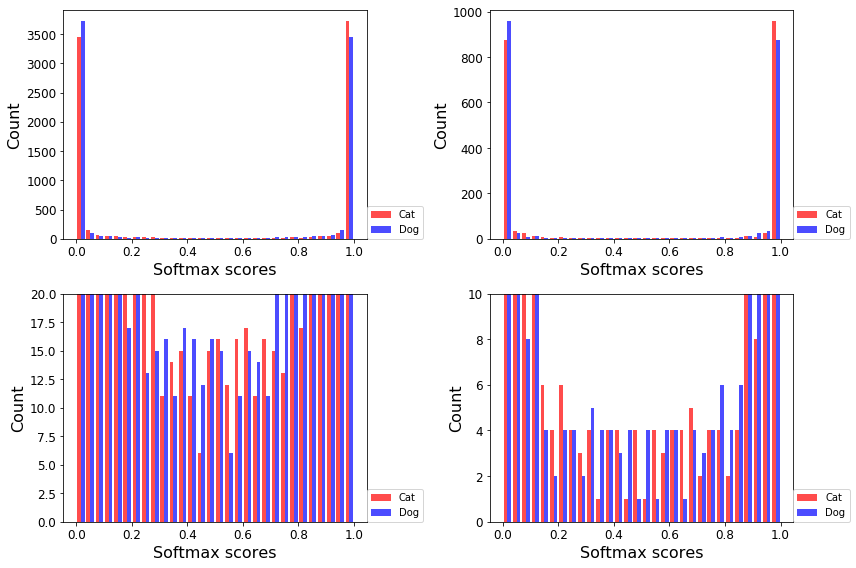

In [23]:
fig = plt.figure(figsize=(12, 8))
fig.add_subplot(2, 2, 1)
plt.hist([scores_train[:, 0], scores_train[:, 1]], color=['r', 'b'], alpha=0.7, bins=30, label=['Cat', 'Dog'])
plt.xlabel('Softmax scores', fontsize=16)
plt.ylabel('Count', fontsize=16)
plt.legend(fontsize=12)
plt.legend(loc=[1., 0])
plt.tick_params(labelsize=12)

fig.add_subplot(2, 2, 2)
plt.hist([scores_test[:, 0], scores_test[:, 1]], color=['r', 'b'], alpha=0.7, bins=30, label=['Cat', 'Dog'])
plt.xlabel('Softmax scores', fontsize=16)
plt.ylabel('Count', fontsize=16)
plt.legend(fontsize=12)
plt.legend(loc=[1., 0])
plt.tick_params(labelsize=12)

fig.add_subplot(2, 2, 3)
plt.hist([scores_train[:, 0], scores_train[:, 1]], color=['r', 'b'], alpha=0.7, bins=30, label=['Cat', 'Dog'])
plt.xlabel('Softmax scores', fontsize=16)
plt.ylabel('Count', fontsize=16)
plt.legend(fontsize=12)
plt.legend(loc=[1., 0])
plt.tick_params(labelsize=12)
plt.ylim([0, 20])

fig.add_subplot(2, 2, 4)
plt.hist([scores_test[:, 0], scores_test[:, 1]], color=['r', 'b'], alpha=0.7, bins=30, label=['Cat', 'Dog'])
plt.xlabel('Softmax scores', fontsize=16)
plt.ylabel('Count', fontsize=16)
plt.legend(fontsize=12)
plt.legend(loc=[1., 0])
plt.tick_params(labelsize=12)
plt.ylim([0, 10])

plt.tight_layout()
plt.savefig('./plot/scores.jpg', dpi=300)

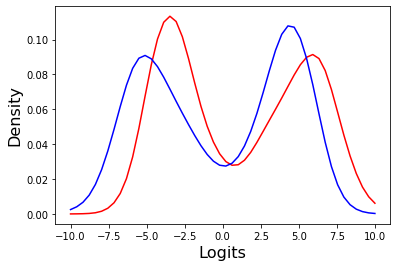

In [26]:
import scipy.stats

kde_cat = scipy.stats.gaussian_kde(logits_train[:,0])
kde_dog = scipy.stats.gaussian_kde(logits_train[:,1])
# prob = kde_cat.pdf(5)
# print('prob', prob)
y_cat = kde_cat(xs)
y_dog = kde_dog(xs)

fig = plt.figure()
xs = np.linspace(-10, 10, num=50)
plt.plot(xs, y_cat, c='red', label='Cat')
plt.plot(xs, y_dog, c='blue', label='Cat')

plt.xlabel('Logits', fontsize=16)
plt.ylabel('Density', fontsize=16)
plt.savefig('./plot/logits_prob.jpg', dpi=300)

[[1.3969800e-01 8.6030203e-01]
 [4.2575645e-01 5.7424355e-01]
 [8.2065320e-01 1.7934676e-01]
 [1.8463819e-04 9.9981540e-01]
 [9.9999595e-01 4.0611371e-06]]


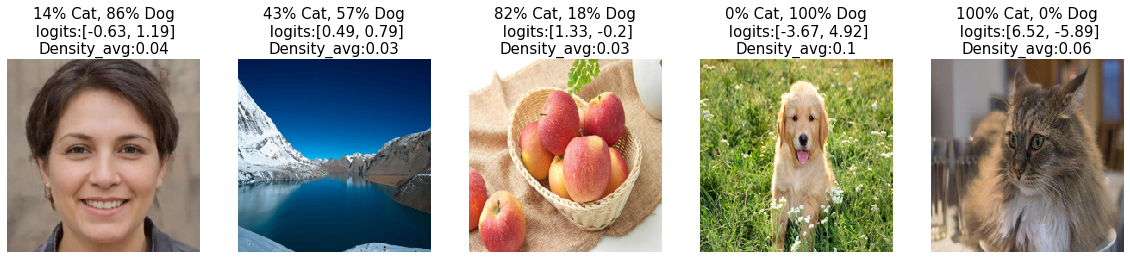

In [30]:
test_imgs = [
    'dataset/face.jpeg',
    'dataset/lake.jpeg',
    'dataset/apple.jpg',
    'dataset/dog.jpg',
    'dataset/cat.jpeg',
]
img_list = [Image.open(img_path).resize((224, 224)) for img_path in test_imgs]

test_batch = torch.stack([test_transform(img).to(device)
                                for img in img_list])

pred_logits_tensor = model(test_batch)
pred_probs = nn.functional.softmax(pred_logits_tensor, dim=1).cpu().data.numpy()
print(pred_probs)

if len(img_list) > 1:
    fig, axs = plt.subplots(1, len(img_list), figsize=(20, 5))
    for idx, img in enumerate(img_list):
        logit_cat = pred_logits_tensor[idx][0].item()
        logit_dog = pred_logits_tensor[idx][1].item()
        density_cat = kde_cat.pdf(logit_cat)[0]
        density_dog = kde_cat.pdf(logit_dog)[0]
        density_avg = (density_cat + density_dog) / 2
        
        ax = axs[idx]
        ax.axis('off')

        ax.set_title("{:.0f}% Cat, {:.0f}% Dog\n logits:[{}, {}]\nDensity_avg:{}".format(100*pred_probs[idx,0],
                    100*pred_probs[idx,1], round(logit_cat,2), round(logit_dog,2), round(density_avg,2)), fontsize=15)
        ax.imshow(img)
else:
    fig = plt.figure()
    img = img_list[0]
    plt.title("{:.0f}% Cat, {:.0f}% Dog\n logits:[{:.2}, {:.2}]".format(
        100*pred_probs[0,0], 100*pred_probs[0,1], pred_logits_tensor[0][0].item(), pred_logits_tensor[0][1].item()), fontsize=15)
    plt.imshow(img)
plt.savefig('./plot/out_of_dataset.jpg', dpi=300)

[[0.21757998 0.78242   ]
 [0.3903599  0.60964006]
 [0.4501766  0.5498234 ]]


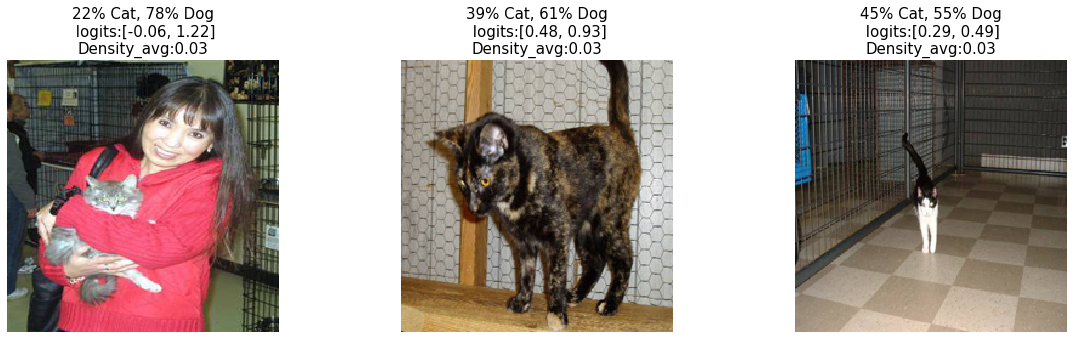

In [32]:
test_imgs = [
    '/home/ubuntu/user_space/dataset/test_set/test_set/cats/cat.4190.jpg',  # wrong_pred_as_cat_high_test
    '/home/ubuntu/user_space/dataset/test_set/test_set/cats/cat.4992.jpg',  # wrong_pred_as_cat_mid_test
    '/home/ubuntu/user_space/dataset/test_set/test_set/cats/cat.4986.jpg',  # wrong_pred_as_cat_low_test
    '/home/ubuntu/user_space/dataset/test_set/test_set/dogs/dog.4507.jpg',  # wrong_pred_as_dog_high_test
]
img_list = [Image.open(img_path).resize((224, 224)) for img_path in test_imgs]

test_batch = torch.stack([test_transform(img).to(device)
                                for img in img_list])

pred_logits_tensor = model(test_batch)
pred_probs = nn.functional.softmax(pred_logits_tensor, dim=1).cpu().data.numpy()
print(pred_probs)

if len(img_list) > 1:
    fig, axs = plt.subplots(1, len(img_list), figsize=(20, 5))
    for idx, img in enumerate(img_list):
        logit_cat = pred_logits_tensor[idx][0].item()
        logit_dog = pred_logits_tensor[idx][1].item()
        density_cat = kde_cat.pdf(logit_cat)[0]
        density_dog = kde_cat.pdf(logit_dog)[0]
        density_avg = (density_cat + density_dog) / 2
        
        ax = axs[idx]
        ax.axis('off')

        ax.set_title("{:.0f}% Cat, {:.0f}% Dog\n logits:[{}, {}]\nDensity_avg:{}".format(100*pred_probs[idx,0],
                    100*pred_probs[idx,1], round(logit_cat,2), round(logit_dog,2), round(density_avg,2)), fontsize=15)
        ax.imshow(img)
else:
    fig = plt.figure()
    img = img_list[0]
    plt.title("{:.0f}% Cat, {:.0f}% Dog\n logits:[{:.2}, {:.2}]".format(
        100*pred_probs[0,0], 100*pred_probs[0,1], pred_logits_tensor[0][0].item(), pred_logits_tensor[0][1].item()), fontsize=15)
    plt.imshow(img)
plt.savefig('./plot/out_of_dataset_1.jpg', dpi=300)